# OpMet Challenge - Interpretability

This notebook uses the basic classification pipeline for ther Falklands rotor problem and uses some tools to interpret the results, particular looking at which features are important.

In [1]:
import pathlib
import datetime
import math
import functools
import numpy
import os

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas

In [4]:
import iris

In [5]:
import matplotlib

In [6]:
%matplotlib inline

In [7]:
import sklearn
import sklearn.tree
import sklearn.preprocessing
import sklearn.ensemble
import sklearn.neural_network
import sklearn.metrics
import sklearn.decomposition
import sklearn.inspection

In [8]:
import shap

In [9]:
import opmet_metrics

In [10]:
try:
    root_data_dir = os.environ['OPMET_ROTORS_DATA_ROOT']
except KeyError:
    root_data_dir = '/data/users/shaddad/ds_cop/2021_opmet_challenge/ML'
root_data_dir = pathlib.Path(root_data_dir)
print(root_data_dir)

/Users/stephen.haddad/data/ml_challenges


## Exploring Falklands Rotor Data

Start by loading the data, seeing what features we have.

In [11]:
falklands_data_path = root_data_dir.joinpath( 'Rotors')
falklands_data_path

PosixPath('/Users/stephen.haddad/data/ml_challenges/Rotors')

In [12]:
falklands_new_training_data_path = pathlib.Path(falklands_data_path, 'new_training.csv')

In [13]:
falklands_training_df = pandas.read_csv(falklands_new_training_data_path, header=0).loc[1:,:]
falklands_training_df

,DTG,air_temp_obs,dewpoint_obs,wind_direction_obs,wind_speed_obs,wind_gust_obs,air_temp_1,air_temp_2,air_temp_3,air_temp_4,...,windspd_18,winddir_19,windspd_19,winddir_20,windspd_20,winddir_21,windspd_21,winddir_22,windspd_22,Rotors 1 is true
1,01/01/2015 00:00,283.9,280.7,110.0,4.1,-9999999.0,284.000,283.625,283.250,282.625,...,5.8,341.0,6.0,334.0,6.1,330.0,6.0,329.0,5.8,NaN
2,01/01/2015 03:00,280.7,279.7,90.0,7.7,-9999999.0,281.500,281.250,280.750,280.250,...,6.8,344.0,5.3,348.0,3.8,360.0,3.2,12.0,3.5,NaN
3,01/01/2015 06:00,279.8,278.1,100.0,7.7,-9999999.0,279.875,279.625,279.125,278.625,...,6.0,345.0,5.5,358.0,5.0,10.0,4.2,38.0,4.0,NaN
4,01/01/2015 09:00,279.9,277.0,120.0,7.2,-9999999.0,279.625,279.250,278.875,278.250,...,3.1,338.0,3.5,354.0,3.9,9.0,4.4,22.0,4.6,NaN
5,01/01/2015 12:00,279.9,277.4,120.0,8.7,-9999999.0,279.250,278.875,278.375,277.875,...,1.6,273.0,2.0,303.0,2.3,329.0,2.5,338.0,2.4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20101,31/12/2020 06:00,276.7,275.5,270.0,3.6,-9999999.0,277.875,277.750,277.625,277.500,...,12.1,223.0,11.8,221.0,11.4,219.0,11.3,215.0,11.4,NaN
20102,31/12/2020 09:00,277.9,276.9,270.0,3.1,-9999999.0,277.875,277.625,277.875,277.875,...,10.2,230.0,10.8,230.0,11.6,227.0,12.3,222.0,12.0,NaN
20103,31/12/2020 12:00,283.5,277.1,220.0,3.6,-9999999.0,281.125,280.625,280.125,279.625,...,10.3,218.0,11.9,221.0,12.8,222.0,11.9,225.0,10.6,NaN
20104,31/12/2020 15:00,286.1,276.9,250.0,3.6,-9999999.0,284.625,284.125,283.625,283.000,...,9.4,218.0,8.6,212.0,8.3,218.0,8.7,226.0,10.1,NaN


In [38]:
num_levels = 22
temp_feature_names = [f'air_temp_{i1}' for i1 in range(1,num_levels+1)]
humidity_feature_names = [f'sh_{i1}' for i1 in range(1,num_levels+1)]
wind_direction_feature_names = [f'winddir_{i1}' for i1 in range(1,num_levels+1)]
wind_speed_feature_names = [f'windspd_{i1}' for i1 in range(1,num_levels+1)]
target_feature_name = 'rotors'

In [23]:
falklands_training_df = falklands_training_df.rename({'Rotors 1 is true': 'rotors'},axis=1)
falklands_training_df.loc[falklands_training_df[falklands_training_df['rotors'].isna()].index, target_feature_name] = 0
falklands_training_df['DTG'] = pandas.to_datetime(falklands_training_df['DTG'])
falklands_training_df = falklands_training_df.drop_duplicates(subset='DTG')
falklands_training_df[target_feature_name]  = falklands_training_df[target_feature_name] .astype(bool)

In [24]:
falklands_training_df.shape

(17507, 96)

### Specify and create input features
Having loaded the data, we then do some preprocessing. This includes:
* Specify feature names
* convert wind speed / direction back to u/v wind. This is because these parameters will vary more smoothly for northerly winds, which is the wind we are interested in.
* prepare the target variable, including filling in missing data.

In [26]:
obs_names = [
    'air_temp_obs',
    'dewpoint_obs',
    'wind_speed_obs',
    'wind_direction_obs',
]

obs_feature_names = [
    'air_temp_obs',
    'dewpoint_obs',
]

In [27]:
falklands_training_df[obs_names]

,air_temp_obs,dewpoint_obs,wind_speed_obs,wind_direction_obs
1,283.9,280.7,4.1,110.0
2,280.7,279.7,7.7,90.0
3,279.8,278.1,7.7,100.0
4,279.9,277.0,7.2,120.0
5,279.9,277.4,8.7,120.0
...,...,...,...,...
20101,276.7,275.5,3.6,270.0
20102,277.9,276.9,3.1,270.0
20103,283.5,277.1,3.6,220.0
20104,286.1,276.9,3.6,250.0


In [28]:
def get_v_wind(wind_dir_name, wind_speed_name, row1):
    return math.cos(math.radians(row1[wind_dir_name])) * row1[wind_speed_name]

def get_u_wind(wind_dir_name, wind_speed_name, row1):
    return math.sin(math.radians(row1[wind_dir_name])) * row1[wind_speed_name]

In [29]:
u_feature_template = 'u_wind_{level_ix}'
v_feature_template = 'v_wind_{level_ix}'
u_wind_feature_names = []
v_wind_features_names = []
for wsn1, wdn1 in zip(wind_speed_feature_names, wind_direction_feature_names):
    level_ix = int( wsn1.split('_')[1])
    u_feature = u_feature_template.format(level_ix=level_ix)
    u_wind_feature_names += [u_feature]
    falklands_training_df[u_feature] = falklands_training_df.apply(functools.partial(get_u_wind, wdn1, wsn1), axis='columns')
    v_feature = v_feature_template.format(level_ix=level_ix)
    v_wind_features_names += [v_feature]
    falklands_training_df[v_feature] = falklands_training_df.apply(functools.partial(get_v_wind, wdn1, wsn1), axis='columns')

In [30]:
wdn1 = 'wind_direction_obs'
wsn1 = 'wind_speed_obs'
u_feature = u_feature_template.format(level_ix='obs')
obs_feature_names += [u_feature]
falklands_training_df[u_feature] = falklands_training_df.apply(functools.partial(get_u_wind, wdn1, wsn1), axis='columns')
v_feature = v_feature_template.format(level_ix='obs')
obs_feature_names += [v_feature]
falklands_training_df[v_feature] = falklands_training_df.apply(functools.partial(get_v_wind, wdn1, wsn1), axis='columns')

In [31]:
falklands_training_df[obs_feature_names]

,air_temp_obs,dewpoint_obs,u_wind_obs,v_wind_obs
1,283.9,280.7,3.852740,-1.402283e+00
2,280.7,279.7,7.700000,4.714890e-16
3,279.8,278.1,7.583020,-1.337091e+00
4,279.9,277.0,6.235383,-3.600000e+00
5,279.9,277.4,7.534421,-4.350000e+00
...,...,...,...,...
20101,276.7,275.5,-3.600000,-6.613093e-16
20102,277.9,276.9,-3.100000,-5.694608e-16
20103,283.5,277.1,-2.314035,-2.757760e+00
20104,286.1,276.9,-3.382893,-1.231273e+00


In [39]:
falklands_training_df[target_feature_name] =  falklands_training_df[target_feature_name]
falklands_training_df.loc[falklands_training_df[falklands_training_df[target_feature_name].isna()].index, target_feature_name] = 0.0
falklands_training_df[target_feature_name]  = falklands_training_df[target_feature_name] .astype(bool)

In [40]:
falklands_training_df[target_feature_name].value_counts()

False    17058
True       449
Name: rotors, dtype: int64

In [41]:
falklands_training_df.columns

Index(['DTG', 'air_temp_obs', 'dewpoint_obs', 'wind_direction_obs',
       'wind_speed_obs', 'wind_gust_obs', 'air_temp_1', 'air_temp_2',
       'air_temp_3', 'air_temp_4',
       ...
       'u_wind_19', 'v_wind_19', 'u_wind_20', 'v_wind_20', 'u_wind_21',
       'v_wind_21', 'u_wind_22', 'v_wind_22', 'u_wind_obs', 'v_wind_obs'],
      dtype='object', length=142)

### Split into traing/validate/test sets
Next step is to split into train/validate/test sets. We split the pandas data frame, then then later extract the actual training data from the dataframe.

In [42]:
test_fraction = 0.1
validation_fraction = 0.1

In [43]:
num_no_rotors = sum(falklands_training_df[target_feature_name] == False)
num_with_rotors = sum(falklands_training_df[target_feature_name] == True)

In [44]:
data_no_rotors = falklands_training_df[falklands_training_df[target_feature_name] == False]
data_with_rotors = falklands_training_df[falklands_training_df[target_feature_name] == True]

In [45]:
data_test = pandas.concat([data_no_rotors.sample(int(test_fraction * num_no_rotors)), data_with_rotors.sample(int(test_fraction * num_with_rotors))])
data_test[target_feature_name].value_counts()

False    1705
True       44
Name: rotors, dtype: int64

In [46]:
falklands_training_df['test_set'] = False
falklands_training_df.loc[data_test.index,'test_set'] = True

In [47]:
data_working = falklands_training_df[falklands_training_df['test_set'] == False]
data_working_no_rotors = data_working[data_working[target_feature_name] == False]
data_working_with_rotors = data_working[data_working[target_feature_name] == True]

In [48]:
data_validation = pandas.concat(
    [data_working_no_rotors.sample(int(validation_fraction * num_no_rotors)), 
     data_working_with_rotors.sample(int(validation_fraction * num_with_rotors))])
falklands_training_df['validation_set'] = False
falklands_training_df.loc[data_validation.index,'validation_set'] = True

In [49]:
data_validation[target_feature_name].value_counts()

False    1705
True       44
Name: rotors, dtype: int64

In [50]:
data_train = falklands_training_df[(~falklands_training_df['test_set']) & (~falklands_training_df['validation_set'])]

In [51]:
data_train[target_feature_name].value_counts()

False    13648
True       361
Name: rotors, dtype: int64

## Train and evaluate machine learning models
Having loaded and transformed the data, we do final prrocessing, train several different classifiers representing different classification algorithms, then evaluate performance.


### Preprocess data into input for ML algorithm
The first step is doing the final preprocessing such as tranforming continous features to have zero mean and unit standard deviation.

In [52]:
input_feature_names = temp_feature_names + humidity_feature_names + u_wind_feature_names + v_wind_features_names

In [53]:
preproc_dict = {}
for if1 in input_feature_names:
    scaler1 = sklearn.preprocessing.StandardScaler()
    scaler1.fit(data_train[[if1]])
    preproc_dict[if1] = scaler1

In [54]:
target_encoder = sklearn.preprocessing.LabelEncoder()
target_encoder.fit(data_train[[target_feature_name]])

LabelEncoder()

Apply transformation to each input column

In [55]:
def preproc_input(data_subset, pp_dict):
    return numpy.concatenate([scaler1.transform(data_subset[[if1]]) for if1,scaler1 in pp_dict.items()],axis=1)

def preproc_target(data_subset, enc1):
     return enc1.transform(data_subset[[target_feature_name]])

In [56]:
X_train = preproc_input(data_train, preproc_dict)
y_train = preproc_target(data_train, target_encoder)

create target feature from rotors

In [57]:
y_train.shape, X_train.shape

((14009,), (14009, 88))

In [58]:
X_val = preproc_input(data_validation, preproc_dict)
y_val = preproc_target(data_validation, target_encoder)

In [59]:
X_test = preproc_input(data_test, preproc_dict)
y_test = preproc_target(data_test, target_encoder)

In [60]:
train_test_dict = {
    'train':     (X_train, y_train),
    'validate':     (X_val, y_val),
    'test': (X_test, y_test),
}
train_val_test_tuples = list(train_test_dict.values())

### Train classifiers

At last we are ready to do machine learning! We will try different algorithms, including a tree based methods, ensembles of trees and neural networks.

In [61]:
classifiers_params = {
    'decision_tree': {'class': sklearn.tree.DecisionTreeClassifier, 'opts': {'max_depth':10, 'class_weight':'balanced'}},
    'random_forest': {'class': sklearn.ensemble.RandomForestClassifier, 'opts': {'max_depth':10, 'class_weight':'balanced'}},
     'ann_5_500': {'class': sklearn.neural_network.MLPClassifier, 'opts': {'hidden_layer_sizes':(500,500,500,500,500)}},   
     'ann_3_700': {'class': sklearn.neural_network.MLPClassifier, 'opts': {'hidden_layer_sizes':(700,700,700)}},   
}



In [62]:
%%time
classifiers_dict = {}             
for clf_name, clf_params in classifiers_params.items():
    print(clf_name)
    clf1 = clf_params['class'](**clf_params['opts'])
    clf1.fit(X_train, y_train)
    classifiers_dict[clf_name] = clf1

decision_tree
random_forest
ann_5_500
ann_3_700
CPU times: user 26min 58s, sys: 39.5 s, total: 27min 38s
Wall time: 7min 51s


### Evaluate classifier performance
Now we take a look at how well our classifiers perform on training and valiation data.

In [63]:
metrics1 = []
for X1, y1 in train_val_test_tuples:
    md1 = {'classifier': [],
           'precision_noRotor': [], 'precision_rotor': [],
           'recall_noRotor': [], 'recall_rotor': [], 
           'f1_noRotor': [], 'f1_rotor': [], 
           'hit_rate': [], 'false_alarm_rate': []
          }
    for clf_name, clf1 in classifiers_dict.items():
        md1['classifier'] += [clf_name]
        prec, recall, f1, support = sklearn.metrics.precision_recall_fscore_support(clf1.predict(X1), y1)
        md1['precision_noRotor'] += [prec[0]]
        md1['precision_rotor'] += [prec[1]]
        md1['recall_noRotor'] += [recall[0]]
        md1['recall_rotor'] += [recall[1]]
        md1['f1_noRotor'] += [f1[0]]
        md1['f1_rotor'] += [f1[1]]
        cm1 = sklearn.metrics.confusion_matrix(clf1.predict(X1), y1)
        hit_rate = cm1[1,1] / (cm1[1,1]+cm1[1,0])
        md1['hit_rate'] += [hit_rate]
        false_alarm_rate = cm1[0,1] / (cm1[0,1]+cm1[0,0])
        md1['false_alarm_rate'] += [false_alarm_rate]
    metrics1 += [md1]

In [64]:
train_metrics_df = pandas.DataFrame(metrics1[0])
val_metrics_df = pandas.DataFrame(metrics1[1])
test_metrics_df = pandas.DataFrame(metrics1[2])

<AxesSubplot:title={'center':'false alarm rate (validate) for rotors present class'}, xlabel='classifier'>

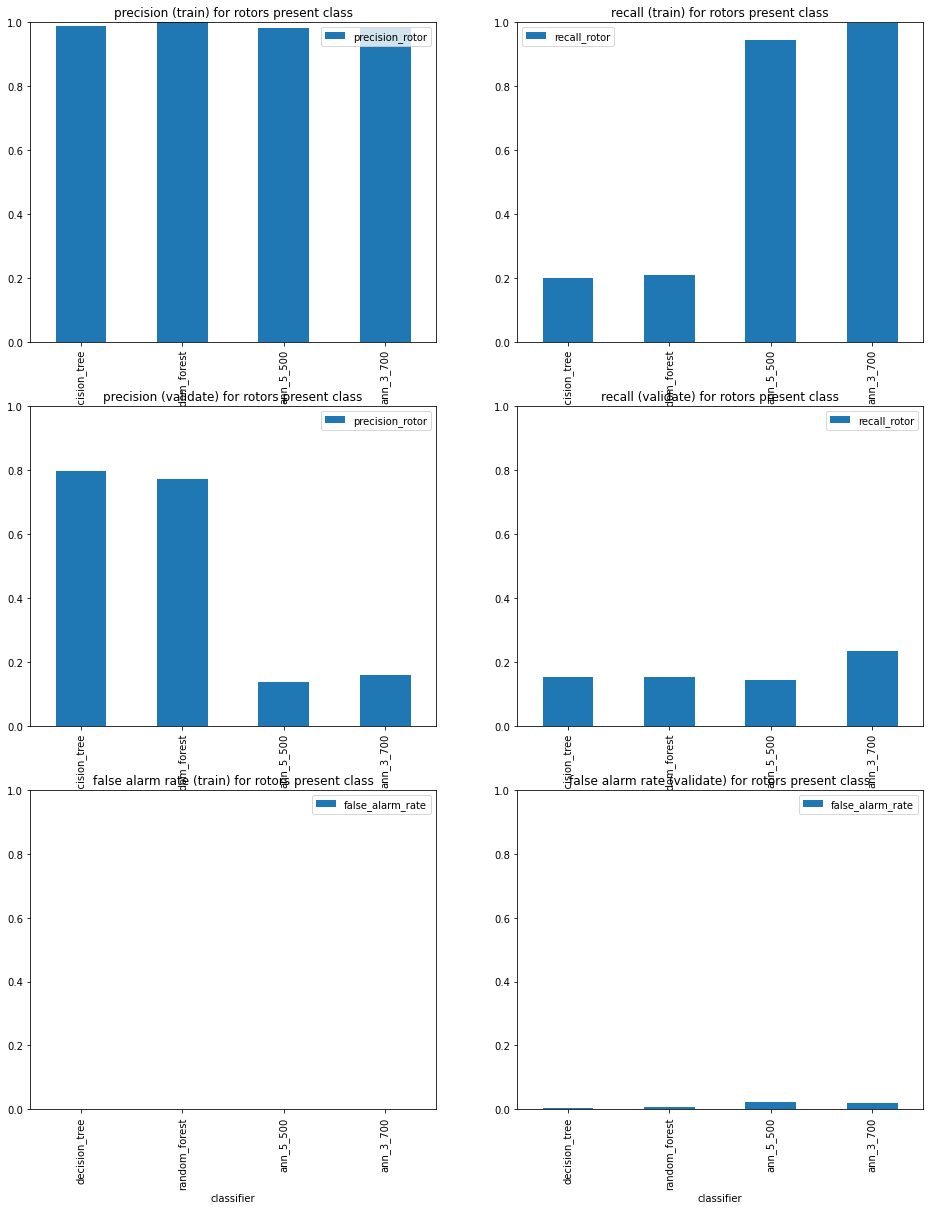

In [65]:
fig1 = matplotlib.pyplot.figure(figsize=(16,20))
ax1 = fig1.add_subplot(3,2,1,title='precision (train) for rotors present class')
train_metrics_df.plot.bar(x='classifier', y='precision_rotor', ax=ax1, ylim=[0,1])
ax1 = fig1.add_subplot(3,2,2,title='recall (train) for rotors present class')
train_metrics_df.plot.bar(x='classifier', y='recall_rotor', ax=ax1, ylim=[0,1])

ax1 = fig1.add_subplot(3,2,3,title='precision (validate) for rotors present class')
val_metrics_df.plot.bar(x='classifier', y='precision_rotor', ax=ax1, ylim=[0,1])
ax1 = fig1.add_subplot(3,2,4,title='recall (validate) for rotors present class')
val_metrics_df.plot.bar(x='classifier', y='recall_rotor', ax=ax1, ylim=[0,1])

ax1 = fig1.add_subplot(3,2,5,title='false alarm rate (train) for rotors present class')
train_metrics_df.plot.bar(x='classifier', y='false_alarm_rate', ax=ax1, ylim=[0,1])
ax1 = fig1.add_subplot(3,2,6,title='false alarm rate (validate) for rotors present class')
val_metrics_df.plot.bar(x='classifier', y='false_alarm_rate', ax=ax1, ylim=[0,1])


We have calculated 4 metrics:
* preccision -  for how many periods classified as "rotor present" actually had a rotor present?
* recall / hit rate - how many periods where rotas were observed were predicted as "rotors present" by the algorithm
* false alarm rate - how many time periods were falsely predicted to have rotors in as propotion of all periods that did not have rotors present

How did we perform
* some algorithms did better or worse at precision and recall
* generlisation from trainingh to validation 

The important thing to consider is what is important to us? In this application, it is most important that we warn of rotors whenever they occur. So a miss is costly. We would like to minismise false alarms, but ,ost important is no misses. We can tune our results to minisies misses. Instead of using the main output, which gives equal weight to False and true classes in the target variable, we can use the predict_proba() function, and change the threshold for declaring something to be true or false (implictly the threshold is 0.5 by default.

In [66]:
def calc_sedi(conf_mat):
    hr1 = conf_mat[1,1] / (conf_mat[1,0] + conf_mat[1,1])
    fa1 = conf_mat[0,1] / (conf_mat[0,0] + conf_mat[0,1])
    sedi_score1 = (
        (numpy.log(fa1) - numpy.log(hr1) - numpy.log(1.0-fa1) + numpy.log(1.0-hr1) )
        / (numpy.log(fa1) + numpy.log(hr1) + numpy.log(1.0 - fa1) + numpy.log(1.0-hr1) )  )
    return sedi_score1

In [67]:
y_train_pred_raw = classifiers_dict['random_forest'].predict_proba(X_train)[:,1]
y_val_pred_raw = classifiers_dict['random_forest'].predict_proba(X_val)[:,1]
y_test_pred_raw = classifiers_dict['random_forest'].predict_proba(X_test)[:,1]

In [68]:
thresholds_list = list(numpy.arange(1e-3,0.995,5e-3))
hit_rates = []
hit_rates_test = []
false_alarm_rates = []
false_alarm_rates_test = []
sedi_list = []
sedi_list_test = []
for threshold in thresholds_list:
    y_pred_train = list(map(float, y_train_pred_raw > threshold)) 
    cm1 = sklearn.metrics.confusion_matrix(y_train, y_pred_train)
    hit_rates += [cm1[1,1] / (cm1[1,0] + cm1[1,1])]
    false_alarm_rates += [cm1[0,1] / (cm1[0,0] + cm1[0,1])]
    sedi_list += [calc_sedi(cm1)]

    y_pred_test = list(map(float, y_test_pred_raw > threshold)) 
    cm1 = sklearn.metrics.confusion_matrix(y_test, y_pred_test)
    hit_rates_test += [cm1[1,1] / (cm1[1,0] + cm1[1,1])]
    false_alarm_rates_test += [cm1[0,1] / (cm1[0,0] + cm1[0,1])]
    sedi_list_test += [calc_sedi(cm1)]

    

In [69]:
numpy.log(hit_rates[1]), numpy.log(false_alarm_rates[1])

(0.0, -0.9179773820741707)

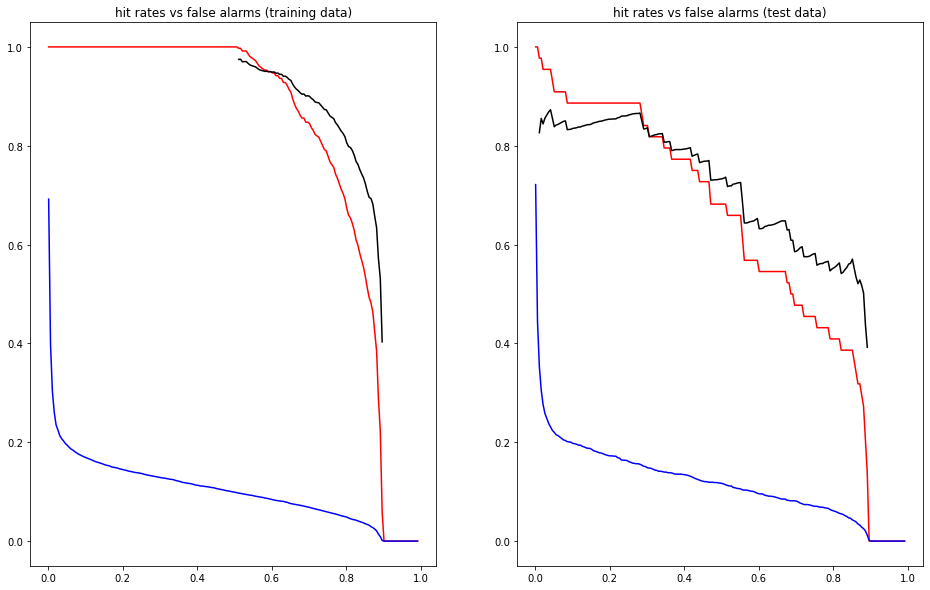

In [70]:
f1 = matplotlib.pyplot.figure(figsize=(16,10))
ax1 = f1.add_subplot(1,2,1,title='hit rates vs false alarms (training data)')
ax1.plot(thresholds_list, hit_rates,'r')
ax1.plot(thresholds_list, false_alarm_rates,'b')
ax1.plot(thresholds_list, sedi_list,'k')

ax1 = f1.add_subplot(1,2,2,title='hit rates vs false alarms (test data)')
ax1.plot(thresholds_list, hit_rates_test,'r')
ax1.plot(thresholds_list, false_alarm_rates_test,'b')
ax1.plot(thresholds_list, sedi_list_test,'k')

## Exploring feature importance

We can look at 
* permutation feature importance
* singular value decomposition


In [72]:
pca1 = sklearn.decomposition.PCA(n_components=10)

In [73]:
pca1.fit(X_train)

PCA(n_components=10)

In [74]:
pca1.get_covariance()

array([[1.00043646, 0.9682737 , 0.97075076, ..., 0.32836976, 0.32788343,
        0.32617066],
       [0.9682737 , 1.01127025, 0.97719926, ..., 0.33823116, 0.33745613,
        0.33542624],
       [0.97075076, 0.97719926, 1.0185436 , ..., 0.34719291, 0.34619212,
        0.34388578],
       ...,
       [0.32836976, 0.33823116, 0.34719291, ..., 1.01335654, 0.96877488,
        0.9557262 ],
       [0.32788343, 0.33745613, 0.34619212, ..., 0.96877488, 0.99978935,
        0.95033728],
       [0.32617066, 0.33542624, 0.34388578, ..., 0.9557262 , 0.95033728,
        0.97620328]])

In [75]:
pca1.singular_values_

array([733.25575227, 519.96360658, 435.60820423, 261.65395267,
       188.21404963, 168.99689799, 148.86755297, 129.63906177,
       112.02377865, 101.62211113])

In [76]:
pca1.components_[2,:]

array([ 0.07966228,  0.07725294,  0.07446263,  0.07055156,  0.06539154,
        0.05927921,  0.05201341,  0.04454583,  0.03805585,  0.03369046,
        0.0322449 ,  0.03318509,  0.03545575,  0.03939767,  0.04455228,
        0.05013447,  0.05554756,  0.06073583,  0.06570616,  0.06939538,
        0.07254452,  0.07485406,  0.09807574,  0.09649028,  0.0953058 ,
        0.09525423,  0.09776151,  0.10343185,  0.11211885,  0.12143118,
        0.12995984,  0.13585226,  0.13689102,  0.13429506,  0.12978848,
        0.12374099,  0.11756329,  0.11079786,  0.10428744,  0.0981544 ,
        0.09237275,  0.08738644,  0.08244935,  0.07710659,  0.01335124,
        0.01652689,  0.02113605,  0.02707785,  0.03471296,  0.04398395,
        0.05324769,  0.06212066,  0.06900851,  0.07291098,  0.07430394,
        0.07385674,  0.07195649,  0.06930143,  0.06578986,  0.06165012,
        0.05782446,  0.05453076,  0.05165062,  0.0488491 ,  0.04617313,
        0.04401884, -0.17648778, -0.17599741, -0.17573432, -0.17

In [77]:
X_train_pca = pca1.transform(X_train)
X_val_pca =  pca1.transform(X_val)
X_test_pca = pca1.transform(X_test)

In [78]:
train_test_pca_dict = {
    'train':     (X_train_pca, y_train),
    'validate':     (X_val_pca, y_val),
    'test': (X_test_pca, y_test),
}
train_val_test_pca_tuples = list(train_test_pca_dict.values())

In [79]:
%%time
classifiers_pca_dict = {}             
for clf_name, clf_params in classifiers_params.items():
    print(clf_name)
    clf1 = clf_params['class'](**clf_params['opts'])
    clf1.fit(X_train_pca, y_train)
    classifiers_pca_dict[clf_name] = clf1

decision_tree
random_forest
ann_5_500
ann_3_700
CPU times: user 17min 41s, sys: 18.1 s, total: 17min 59s
Wall time: 4min 48s


In [80]:
metrics_pca, metrics_pca_df_list = opmet_metrics.calculate_metric_suite(
    classifiers_pca_dict,
    train_test_pca_dict,
)

<AxesSubplot:title={'center':'false alarm rate (validate) for rotors present class'}, xlabel='classifier'>

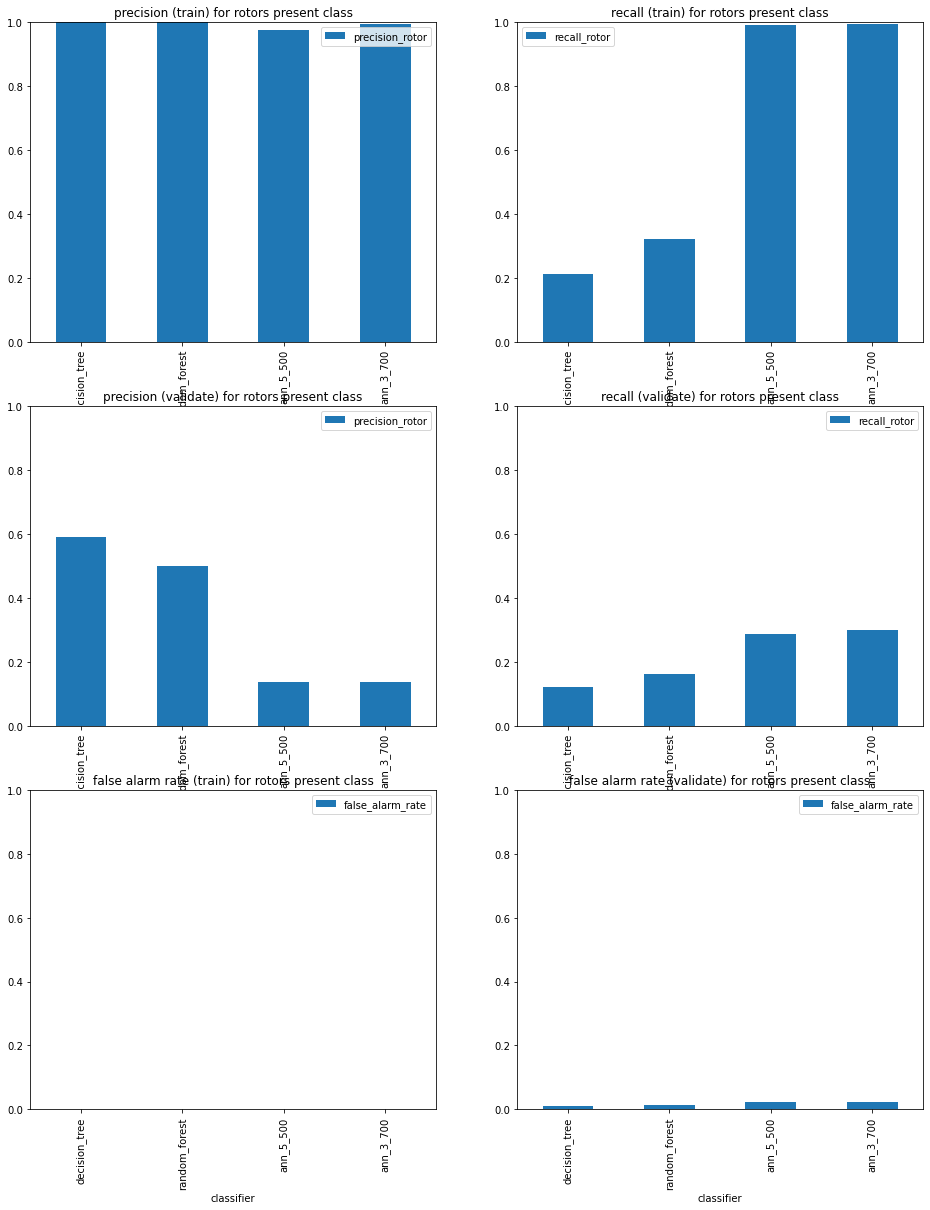

In [81]:
fig1 = matplotlib.pyplot.figure(figsize=(16,20))
ax1 = fig1.add_subplot(3,2,1,title='precision (train) for rotors present class')
metrics_pca_df_list['train'].plot.bar(x='classifier', y='precision_rotor', ax=ax1, ylim=[0,1])
ax1 = fig1.add_subplot(3,2,2,title='recall (train) for rotors present class')
metrics_pca_df_list['train'].plot.bar(x='classifier', y='recall_rotor', ax=ax1, ylim=[0,1])

ax1 = fig1.add_subplot(3,2,3,title='precision (validate) for rotors present class')
metrics_pca_df_list['test'].plot.bar(x='classifier', y='precision_rotor', ax=ax1, ylim=[0,1])
ax1 = fig1.add_subplot(3,2,4,title='recall (validate) for rotors present class')
metrics_pca_df_list['test'].plot.bar(x='classifier', y='recall_rotor', ax=ax1, ylim=[0,1])

ax1 = fig1.add_subplot(3,2,5,title='false alarm rate (train) for rotors present class')
metrics_pca_df_list['train'].plot.bar(x='classifier', y='false_alarm_rate', ax=ax1, ylim=[0,1])
ax1 = fig1.add_subplot(3,2,6,title='false alarm rate (validate) for rotors present class')
metrics_pca_df_list['test'].plot.bar(x='classifier', y='false_alarm_rate', ax=ax1, ylim=[0,1])

In [82]:
sedi_pca_dict = {}
for set_name, (X1, y1) in train_test_pca_dict.items():
    set_sedi_dict = {}
    for clf_name, clf1 in classifiers_pca_dict.items():
        y_pred_raw = clf1.predict_proba(X1)[:, 1]
        set_sedi_dict[clf_name] = opmet_metrics.calculate_sedi_suite(thresholds_list,
                                                                     y1,
                                                                     y_pred_raw)
    sedi_pca_dict[set_name] = set_sedi_dict


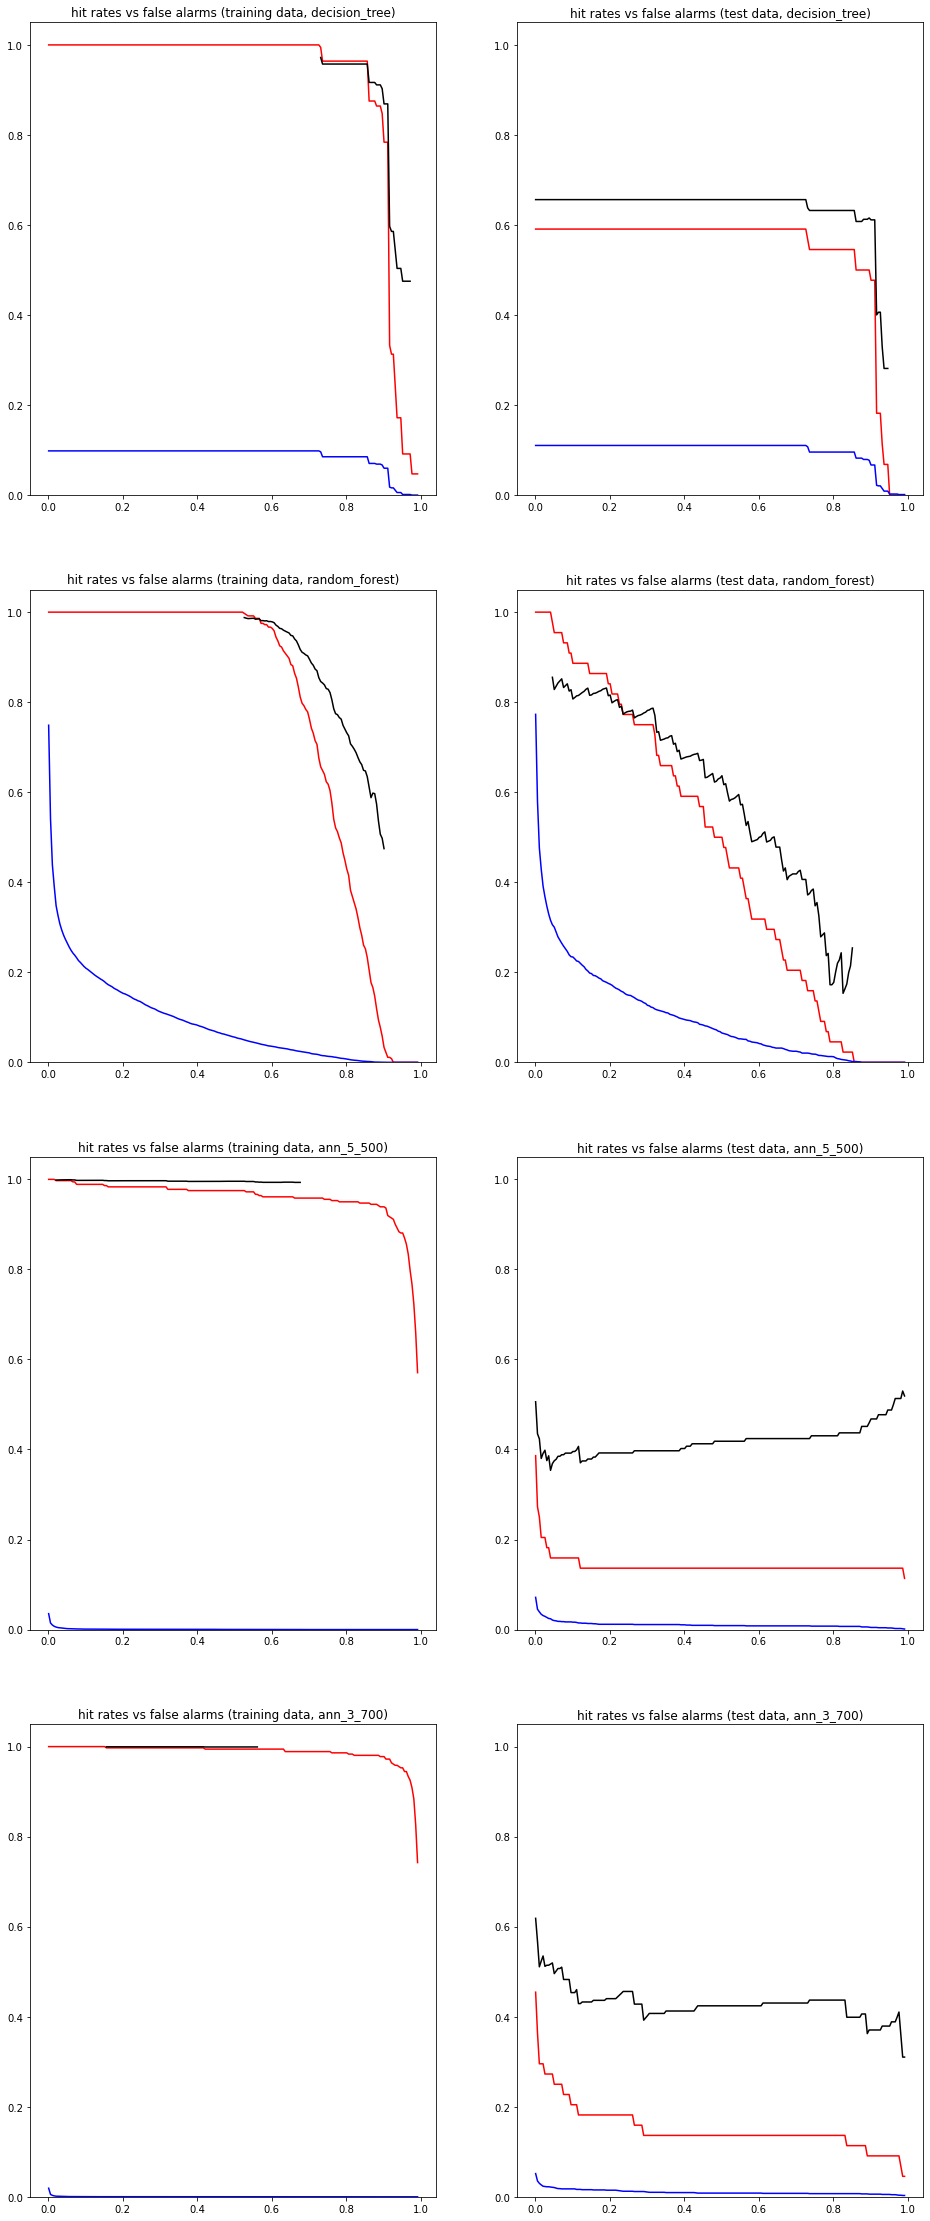

In [83]:
f1 = matplotlib.pyplot.figure(figsize=(16,10*len(classifiers_dict)))
plot_ix = 0
for clf_name, clf1 in classifiers_pca_dict.items():
    ax1 = f1.add_subplot(len(classifiers_dict),2,plot_ix + 1,title=f'hit rates vs false alarms (training data, {clf_name})')
    ax1.plot(thresholds_list, sedi_pca_dict['train'][clf_name]['hit_rates'],'r')
    ax1.plot(thresholds_list, sedi_pca_dict['train'][clf_name]['false_alarm_rates'],'b')
    ax1.plot(thresholds_list, sedi_pca_dict['train'][clf_name]['sedi_list'],'k')
    ax1.set_ylim((0.0,1.05))

    ax1 = f1.add_subplot(len(classifiers_dict),2,plot_ix+2,title=f'hit rates vs false alarms (test data, {clf_name})')
    ax1.plot(thresholds_list, sedi_pca_dict['test'][clf_name]['hit_rates'],'r')
    ax1.plot(thresholds_list, sedi_pca_dict['test'][clf_name]['false_alarm_rates'],'b')
    ax1.plot(thresholds_list, sedi_pca_dict['test'][clf_name]['sedi_list'],'k')
    ax1.set_ylim((0.0,1.05))
    plot_ix += 2

Permutation importance

In [84]:
feature_imp_dict = {}
for clf_name, clf1 in classifiers_dict.items():
    feature_imp_dict[clf_name] = sklearn.inspection.permutation_importance(clf1, X_train, y_train)

In [85]:
numpy.argsort(feature_imp_dict['random_forest']['importances_mean'])[:10]

array([71, 70, 69, 12, 68, 16, 72, 11, 10, 79])

In [ ]:
feature_imp_dict

In [86]:
[input_feature_names[n1] for n1 in numpy.argsort(feature_imp_dict['random_forest']['importances_mean'])[:10]]

['v_wind_6',
 'v_wind_5',
 'v_wind_4',
 'air_temp_13',
 'v_wind_3',
 'air_temp_17',
 'v_wind_7',
 'air_temp_12',
 'air_temp_11',
 'v_wind_14']

### Feature importance using shapley values

Shapley values use a game theory approach to evaluating the importance of each of the "players" (features) in the "game" (inputs to the model).

https://shap.readthedocs.io/en/latest/index.html


In [ ]:
import shap

In [ ]:
# explainer = shap.KernelExplainer(classifiers_dict['decision_tree'].predict_proba, X_train)
# shap_values = explainer.shap_values(X_test)
# shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)